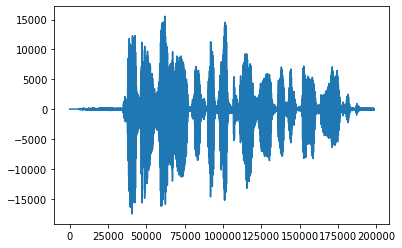

In [1]:
from scipy import signal
from scipy.io import wavfile

from scipy.fftpack import fft, fftfreq, ifft

import matplotlib.pyplot as plt
import numpy as np

freq, x = wavfile.read('mono3.wav')

plt.plot(x)

/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


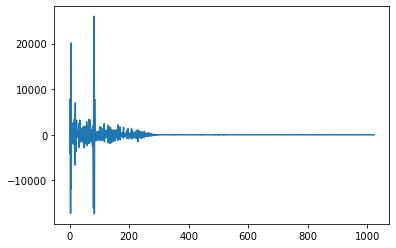

In [2]:
N = 2048
over = 0.25
resolution = float(freq) / N

rangeup_r = 350
rangedown_r = 160
rangeup = rangeup_r / resolution
rangedown = rangedown_r / resolution

buf = []
bufs = []
numofcycle = 1
curs = 0
cycle = 0

while curs < len(x):
	if cycle >= N:
		if curs >= len(x):
			break
		curs -= int(N * over)
		bufs.append(buf)
		buf = []
		numofcycle += 1
		cycle = 0
		continue
	buf.append(x[curs])
	curs += 1
	cycle += 1

hammin = np.hamming(N)
periods = []
for period in bufs:
	period *= hammin;
	periods.append(fft(period)[:N//2])

plt.plot(periods[15])

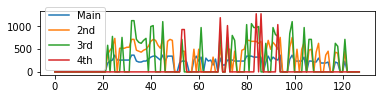

In [3]:
maintone = [[],[],[],[]] # per, freq, pernum, freqnum
periodnum = 0

per_absolute_max = 0

for period in periods:
	per_max = 0
	freq_max = 0
	for i in range(int(np.floor(rangedown)), int(np.ceil(rangeup) + 1)):
		if np.abs(period[i]) > per_max:
			per_max = np.abs(period[i])
			freq_max = i
	if per_max < 150000:
		per_max = 0
		freq_max = 0
	maintone[0].append(per_max)
	if per_max > per_absolute_max:
		per_absolute_max = per_max
		absfreq = freq_max
		abspernum = periodnum

	maintone[1].append(freq_max * resolution)
	maintone[2].append(periodnum)
	maintone[3].append(freq_max)
	periodnum += 1

periodnum = 0
formant = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]	 # 3x [per, freq, pernum, freqnum]
second1 = []
second2 = []
for period in periods:
	harmonics = [0, 0, 0]
	freqses = [0, 0, 0]
	for j in range(2, 5):
		for i in range(maintone[3][periodnum] * j - 1, maintone[3][periodnum] * j + 2):
			if np.abs(period[i]) > harmonics[j - 2] and np.abs(period[i]) < maintone[0][periodnum] * pow(0.1, j - 1):
				harmonics[j - 2] = np.abs(period[i])
				freqses[j - 2] = i

		formant[j - 2][0].append(harmonics[j - 2])
		formant[j - 2][1].append(resolution * freqses[j - 2])
		formant[j - 2][2].append(periodnum)
		formant[j - 2][3].append(freqses[j - 2])

	periodnum += 1

plt.subplot(3,1,3)
plt.plot(maintone[2], maintone[1], label="Main")
plt.plot(formant[0][2], formant[0][1], label="2nd")
plt.plot(formant[1][2], formant[1][1], label="3rd")
plt.plot(formant[2][2], formant[2][1], label="4th")
plt.legend()
plt.show()

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


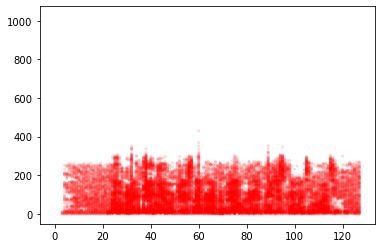

In [4]:
def getcolor(inp):
	for i in range(1,11):
		if inp > per_absolute_max / (pow(i, 4)):
			return (1, 0, 0, 1.0 / i)
	return (0,0,0,0)

boundaries = (50, 4000)
steps = 1024

periodnum = 0
toplotx = []
toploty = []
toplotcol = []
for period in periods:
	innum = 0
	for i in period:
		val = int(np.round(i))
		toplotx.append(periodnum)
		toploty.append(innum)
		toplotcol.append(getcolor(val))
		
		innum += 1
	periodnum += 1

plt.scatter(toplotx, toploty, s=5, c=toplotcol)
